In [1]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path)
rna = data['rna_train']
atac = data['atac_train_small']

In [3]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

In [4]:
print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

rna zero frac: 0.0
atac zero frac: 0.9740022531413609


In [5]:
list(data.keys())

['peak_selector',
 'atac_train_small',
 'atac_test_small',
 'rna_train',
 'rna_test',
 'rna_good_feats',
 'train_idx',
 'test_idx',
 'cell_type_train',
 'cell_type_test']

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
import pandas as pd
gene_list = pd.read_csv(f'{data_root}/gene_list.csv', header=None)

In [8]:
chosen_genes = gene_list[data['rna_good_feats']]

In [9]:
from os.path import join as opj
import numpy as np

data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
cell_labels_train = data['cell_type_train']

In [10]:
cell_labels_train.shape

(6897,)

In [11]:
from GanoliModel import GanoliLogisticGAN
model_cls = GanoliLogisticGAN

Global seed set to 42


In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
checkpoint_dir = '/om2/user/rogerjin/GANOLI/ganoli/models/logs/logistic_embed_corr/default/version_0/checkpoints/'
checkpoint = 'epoch=52-val_oracle_total=1.29.ckpt'
checkpoint_path = f'{checkpoint_dir}/{checkpoint}'
ckpt_model = model_cls.load_from_checkpoint(checkpoint_path=checkpoint_path, rna_shape=7445, atac_shape=3808)

In [14]:
ckpt_model.to('cuda:0')

GanoliLogisticGAN(
  (generator_rna2atac): GanoliLogisticGenerator(
    (linear): Linear(in_features=7445, out_features=3808, bias=True)
    (sigmoid): Sigmoid()
  )
  (generator_atac2rna): GanoliLinearGenerator(
    (model): Linear(in_features=3808, out_features=7445, bias=True)
  )
  (discriminator_rna): GanoliLinearDiscriminator(
    (model): Linear(in_features=7445, out_features=1, bias=True)
  )
  (discriminator_atac): GanoliLinearDiscriminator(
    (model): Linear(in_features=3808, out_features=1, bias=True)
  )
  (reconstruction_loss_fn): MSELoss()
  (identity_loss_fn): MSELoss()
  (generator_loss_fn): BCEWithLogitsLoss()
  (discriminator_loss_fn): BCEWithLogitsLoss()
)

In [15]:
atac_val = data['atac_test_small']

In [16]:
import torch
atac_val = torch.Tensor(atac_val).to('cuda:0')

In [17]:
atac_val_mini = atac_val[:10, :]

In [18]:
rna_val_pred = ckpt_model(atac_val,data_type='atac')

In [19]:
rna_val_pred.shape

torch.Size([2300, 7445])

In [20]:
rna_val_labels = data['cell_type_test']

In [21]:
import umap
reducer = umap.UMAP(densmap=True) 
rna_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())

In [22]:
rna_trans.shape

(2300, 2)

In [23]:
import benplot

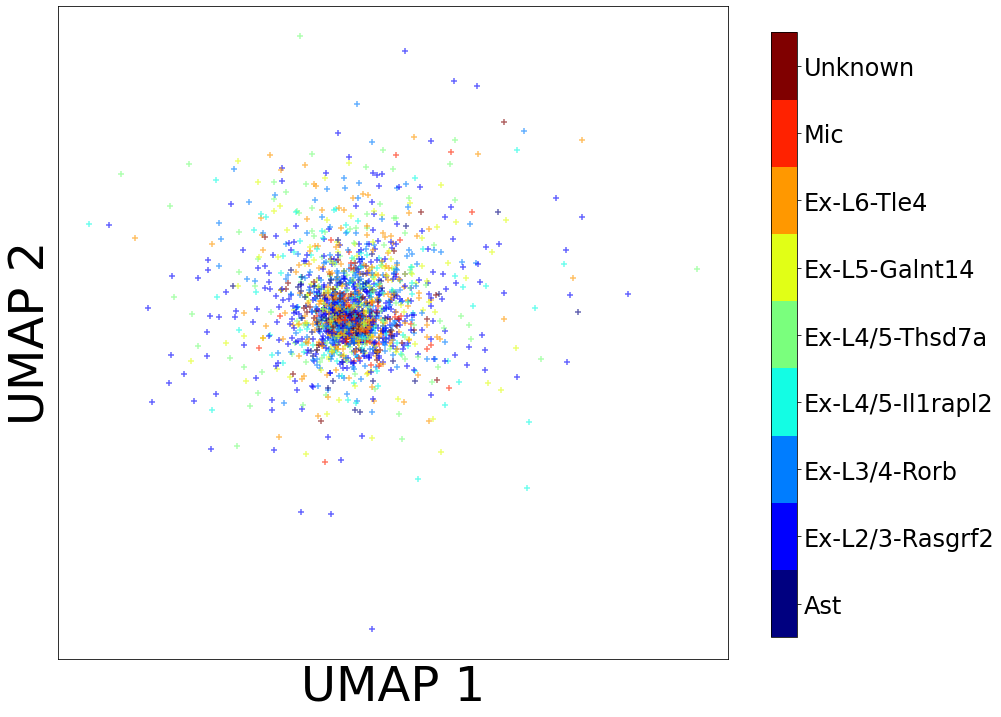

In [24]:
benplot.plot_lowdim_rep(rna_trans, rna_val_labels)

In [25]:
rna_val = data['rna_test']
reducer = umap.UMAP(densmap=True, min_dist=0.001) 
rna_true_trans = reducer.fit_transform(rna_val)

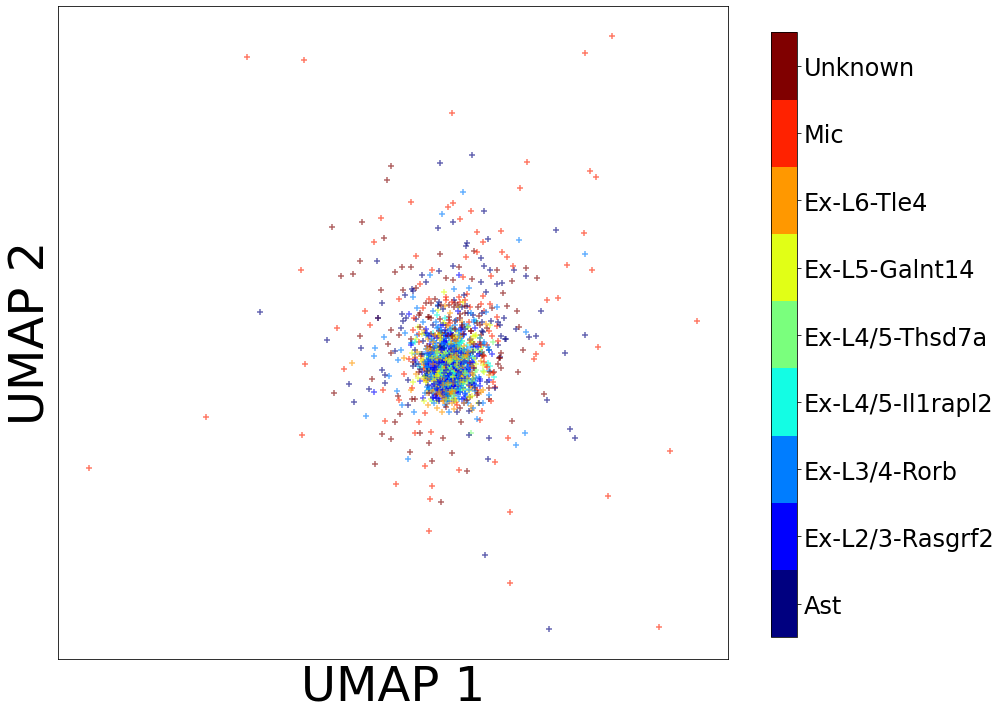

In [26]:
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

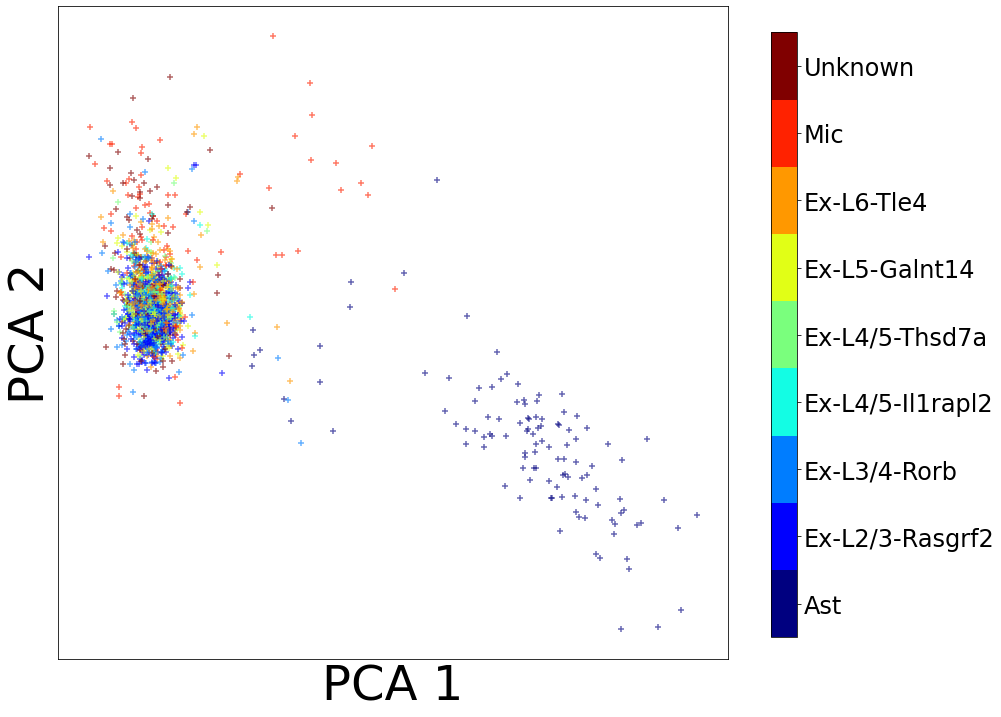

In [36]:
from sklearn.decomposition import PCA

rna_val = data['rna_test']
reducer = PCA(n_components=2) 
rna_true_trans = reducer.fit_transform(rna_val)
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

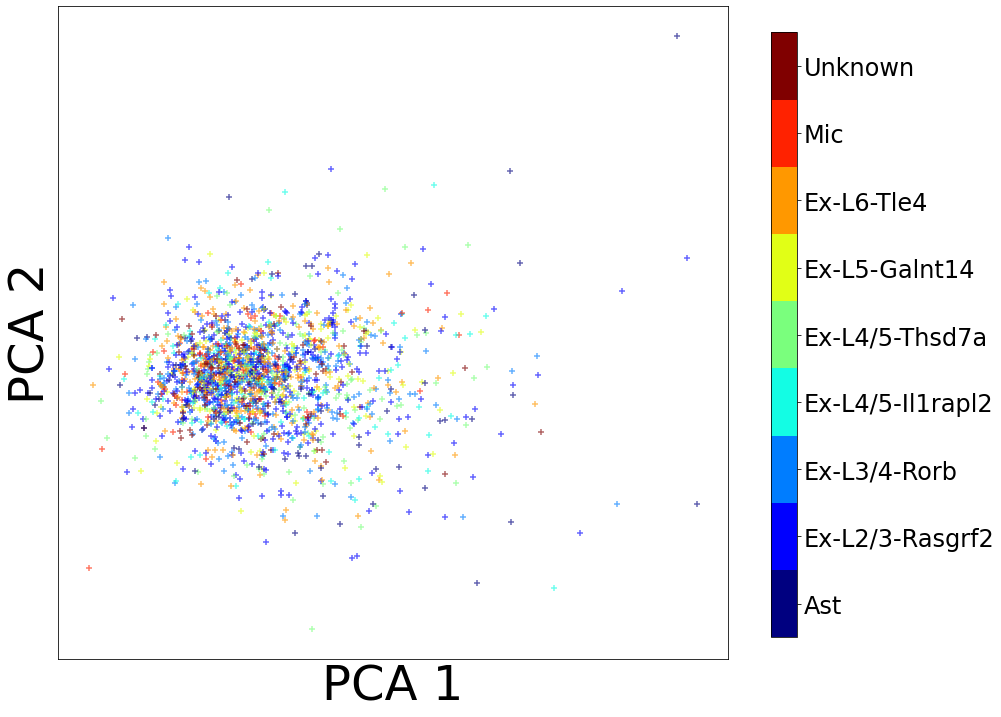

In [38]:
reducer = PCA(n_components=2) 
rna_pred_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())
benplot.plot_lowdim_rep(rna_pred_trans, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

In [29]:
rna_val = torch.Tensor(rna_val).to('cuda:0')
atac_val_pred = ckpt_model(rna_val,data_type='rna')

In [30]:
atac_val_pred

tensor([[4.7687e-03, 4.5683e-03, 2.1118e-01,  ..., 4.0028e-01, 7.7845e-02,
         8.0349e-02],
        [9.9397e-01, 1.2188e-01, 1.6933e-01,  ..., 9.9958e-01, 5.0553e-02,
         9.5221e-01],
        [1.2959e-03, 1.1168e-04, 1.7774e-02,  ..., 1.1736e-02, 5.0413e-04,
         1.4536e-03],
        ...,
        [8.7654e-01, 9.4091e-01, 1.5562e-02,  ..., 5.3236e-01, 3.4734e-02,
         3.4279e-01],
        [1.3466e-05, 2.4181e-04, 7.1114e-07,  ..., 2.6498e-08, 1.3753e-02,
         9.5066e-02],
        [1.9475e-05, 6.7049e-06, 2.6352e-01,  ..., 4.1207e-01, 5.0699e-01,
         9.5501e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [31]:
atac_val_pred

tensor([[4.7687e-03, 4.5683e-03, 2.1118e-01,  ..., 4.0028e-01, 7.7845e-02,
         8.0349e-02],
        [9.9397e-01, 1.2188e-01, 1.6933e-01,  ..., 9.9958e-01, 5.0553e-02,
         9.5221e-01],
        [1.2959e-03, 1.1168e-04, 1.7774e-02,  ..., 1.1736e-02, 5.0413e-04,
         1.4536e-03],
        ...,
        [8.7654e-01, 9.4091e-01, 1.5562e-02,  ..., 5.3236e-01, 3.4734e-02,
         3.4279e-01],
        [1.3466e-05, 2.4181e-04, 7.1114e-07,  ..., 2.6498e-08, 1.3753e-02,
         9.5066e-02],
        [1.9475e-05, 6.7049e-06, 2.6352e-01,  ..., 4.1207e-01, 5.0699e-01,
         9.5501e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [32]:
type(atac_val)

torch.Tensor

In [33]:
from sklearn.metrics import roc_auc_score
import pandas as pd

aurocs = []
for i in range(atac_val.shape[1]):
    auroc = roc_auc_score(atac_val[:, i].detach().cpu().numpy(), atac_val_pred[:, i].detach().cpu().numpy())
    aurocs.append(auroc)

atac_rocs = pd.DataFrame()
atac_rocs['auroc'] = aurocs

array([[<AxesSubplot:title={'center':'auroc'}>]], dtype=object)

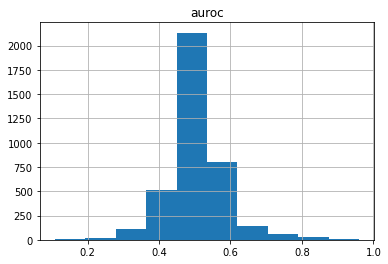

In [34]:
atac_rocs.hist()

In [35]:
atac_rocs.mean()

auroc    0.50486
dtype: float64